<a href="https://colab.research.google.com/github/edoardochiavazza/DBA/blob/master/notebooks/train-yolov9-object-detection-on-custom-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train YOLOv9 on a Custom Dataset
---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov9-model/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/WongKinYiu/yolov9)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/XHT2c8jT3Bc)
[![arXiv](https://img.shields.io/badge/arXiv-2402.13616-b31b1b.svg)](https://arxiv.org/pdf/2402.13616.pdf)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sat Nov 22 16:46:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [12]:
!rm -rf /content/yolov9

In [3]:
!git clone https://github.com/WongKinYiu/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 781, done.
remote: Total 781 (delta 0), reused 0 (delta 0), pack-reused 781 (from 1)
Receiving objects: 100% (781/781), 3.27 MiB | 24.99 MiB/s, done.
Resolving deltas: 100% (330/330), done.
/content/yolov9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.5 MB/s eta 0:00:00


**NOTE:** Let's install the [`roboflow`](https://pypi.org/project/roboflow) package, which we will use to download our dataset from [Roboflow Universe](https://universe.roboflow.com/).

In [4]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 113.7 MB/s eta 0:00:00


In [5]:
!ls -la {HOME}/weights

ls: cannot access '/content/weights': No such file or directory


**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [6]:
%cd {HOME}/yolov9

/content/yolov9


In [7]:
from roboflow import Roboflow
rf = Roboflow(api_key="BlHvnKXuHZFTLUKkppbq")
project = rf.workspace("edoardo-chiavazza-cyfj2").project("llm-oriented-object-detection-padella-qiddp-1rgvr")
version = project.version(3)
dataset = version.download("yolov9")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to LLM-Oriented-Object-Detection-PADELLA-3 in yolov9:: 100%|██████████| 674/674 [00:00<00:00, 12128.30it/s]


## Train Custom Model

In [8]:
print({dataset.location})

{'/content/yolov9/LLM-Oriented-Object-Detection-PADELLA-3'}


In [11]:
%cd {HOME}/yolov9

!sed -i "s/ckpt = torch.load(weights, map_location='cpu')/ckpt = torch.load(weights, map_location='cpu', weights_only=False)/g" train.py

/content/yolov9


In [17]:
%cd /content/yolov9

# 1. Resetta il file val.py allo stato originale (pulito)
!git checkout val.py

# 2. Correzione OUTPUT MODELLO in val.py (gestione lista/tupla)
# Inserisce il controllo dopo la riga 'preds = model(img)'
!sed -i "/preds = model(img)/a\ \ \ \ \ \ \ \ \ \ \ \ if isinstance(preds, (list, tuple)): preds = preds[0]" val.py

# 3. Correzione LOSS in val.py (Sostituisce la riga che crasha con 'pass')
# Usiamo 'pass' così il blocco 'if' non rimane vuoto
!sed -i "s/loss += compute_loss(train_out, targets)\[1\]/pass/" val.py

# 4. Correzione GRAFICI in utils/plots.py (Pillow 10+)
!sed -i "s/w, h = self.font.getsize(label)/_, _, w, h = self.font.getbbox(label)/" utils/plots.py

print("✅ File val.py e plots.py riparati correttamente!")

/content/yolov9
Updated 1 path from the index
✅ File val.py e plots.py riparati correttamente!


In [18]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 300 --img 160 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/yolov9-t-converted.pt \
--cfg models/detect/yolov9-t.yaml \
--hyp hyp.scratch-high.yaml

Output streaming troncato alle ultime 5000 righe.
    157/299      0.73G      1.713      1.481      1.168        311        160:  93% 14/15 [00:04<00:00,  4.01it/s]Tipo di pred: <class 'list'>
Lunghezza di pred: 2
    157/299      0.73G      1.718      1.477      1.162        370        160: 100% 15/15 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:00<00:00,  3.06it/s]
                   all         31        232      0.682      0.641      0.707      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
  0% 0/15 [00:00<?, ?it/s]Tipo di pred: <class 'list'>
Lunghezza di pred: 2
    158/299      0.73G      1.893      1.492      1.148        386        160:   7% 1/15 [00:00<00:10,  1.33it/s]Tipo di pred: <class 'list'>
Lunghezza di pred: 2
    158/299      0.73G       1.66      1.454      1.175        169        160:  13% 2/15 [00:01<00:07,  1.81it/s]Tipo di pred: <class 'list'

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [ ]:
!ls {HOME}/yolov9/runs/train/exp/

confusion_matrix.png				    P_curve.png       train_batch2.jpg
events.out.tfevents.1709205293.f80636ca2632.2700.0  PR_curve.png      val_batch0_labels.jpg
F1_curve.png					    R_curve.png       val_batch0_pred.jpg
hyp.yaml					    results.csv       val_batch1_labels.jpg
labels_correlogram.jpg				    results.png       val_batch1_pred.jpg
labels.jpg					    train_batch0.jpg  weights
opt.yaml					    train_batch1.jpg


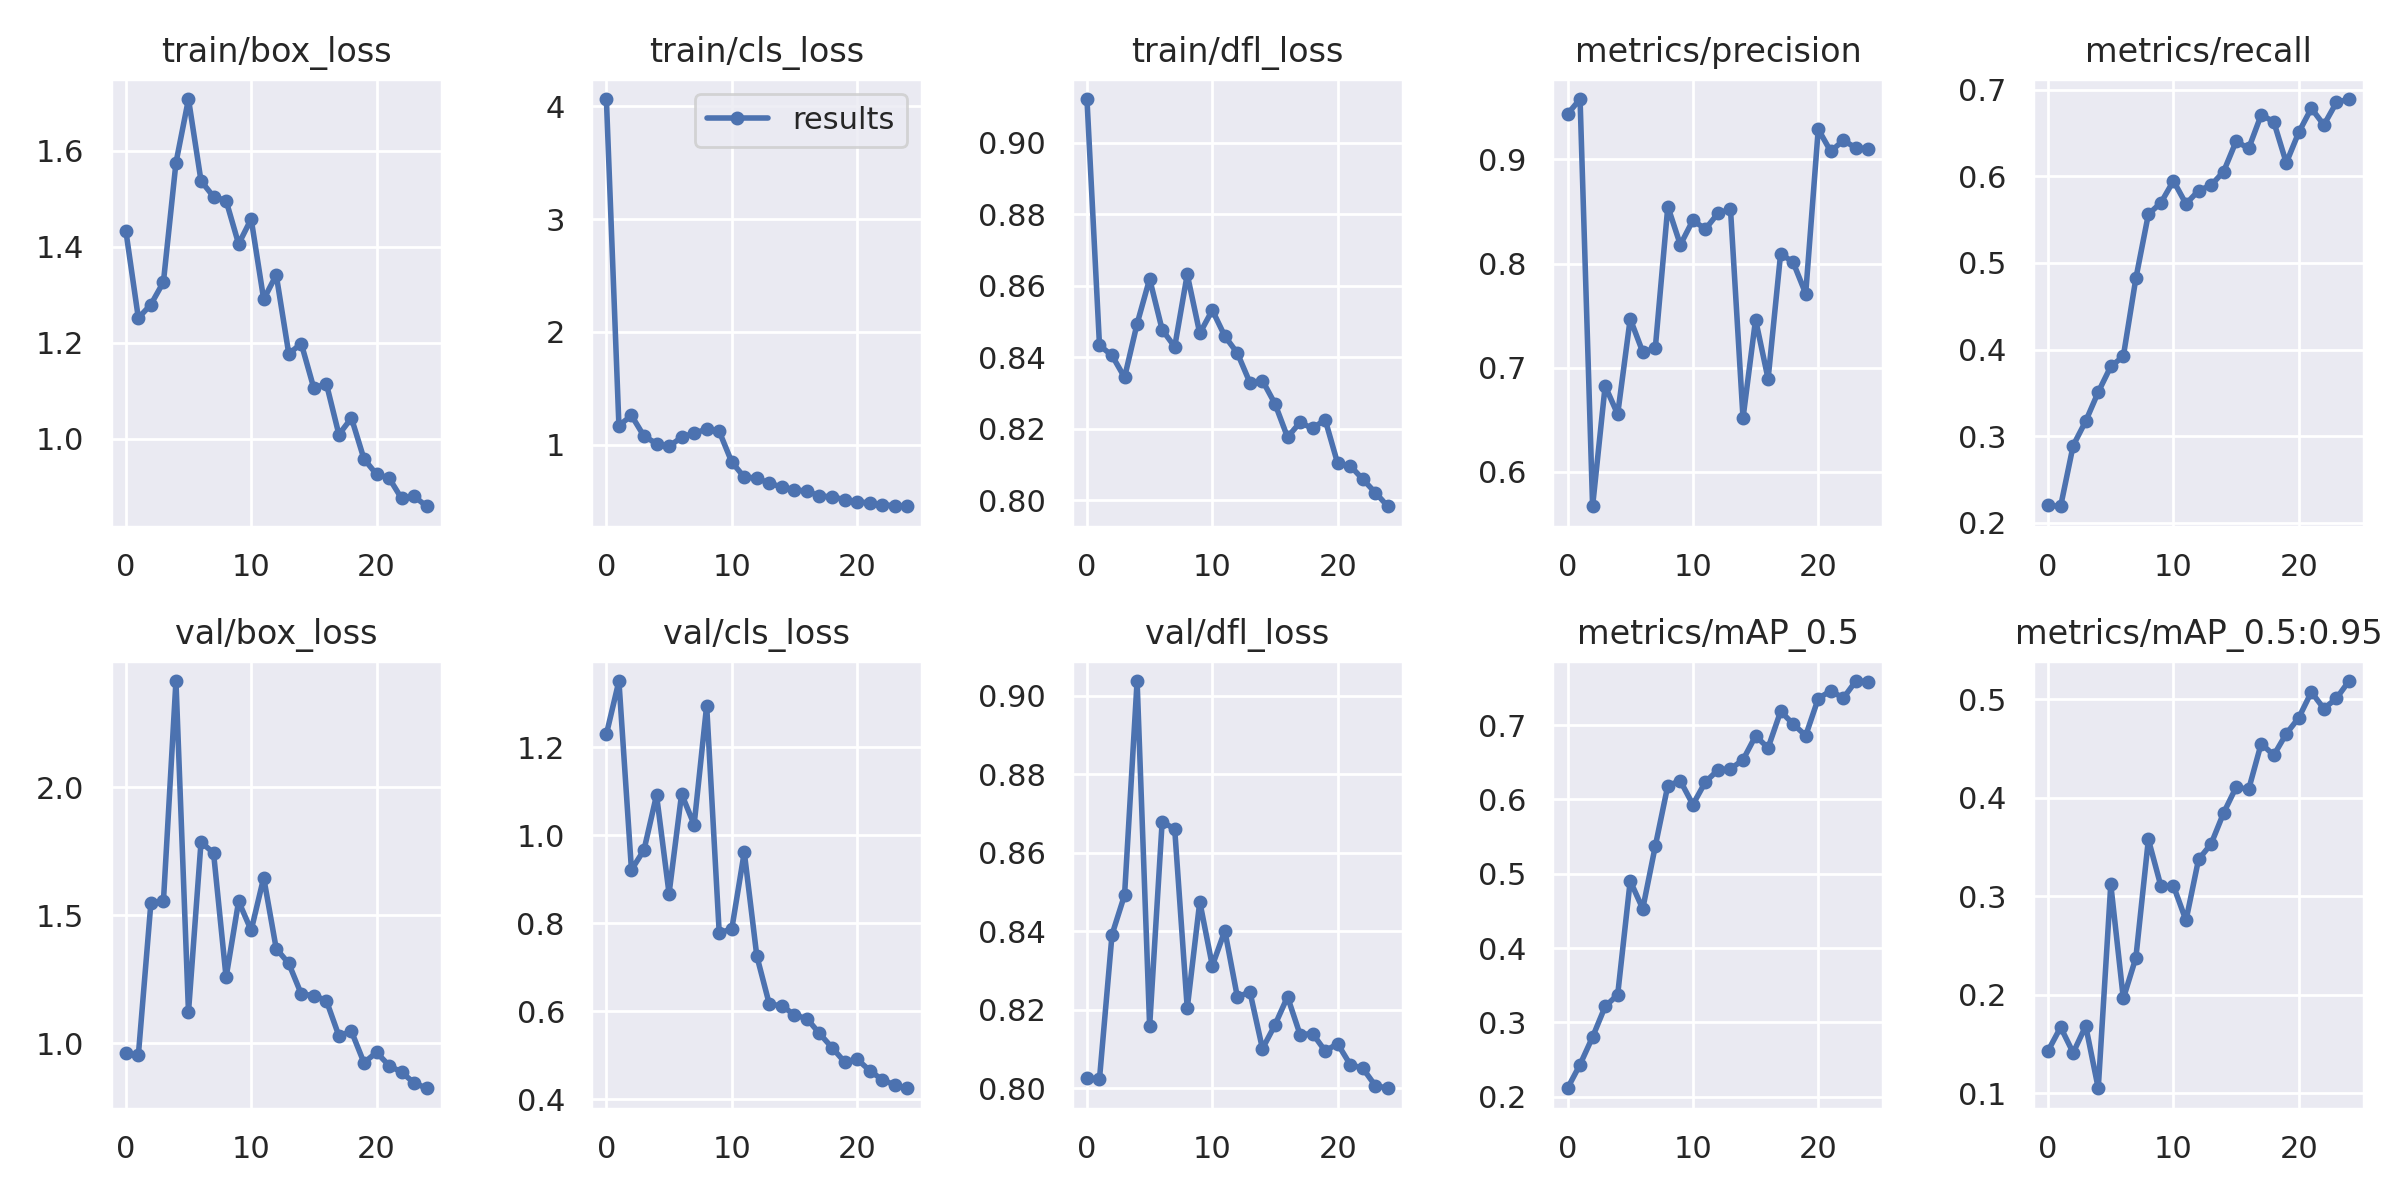

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=1000)

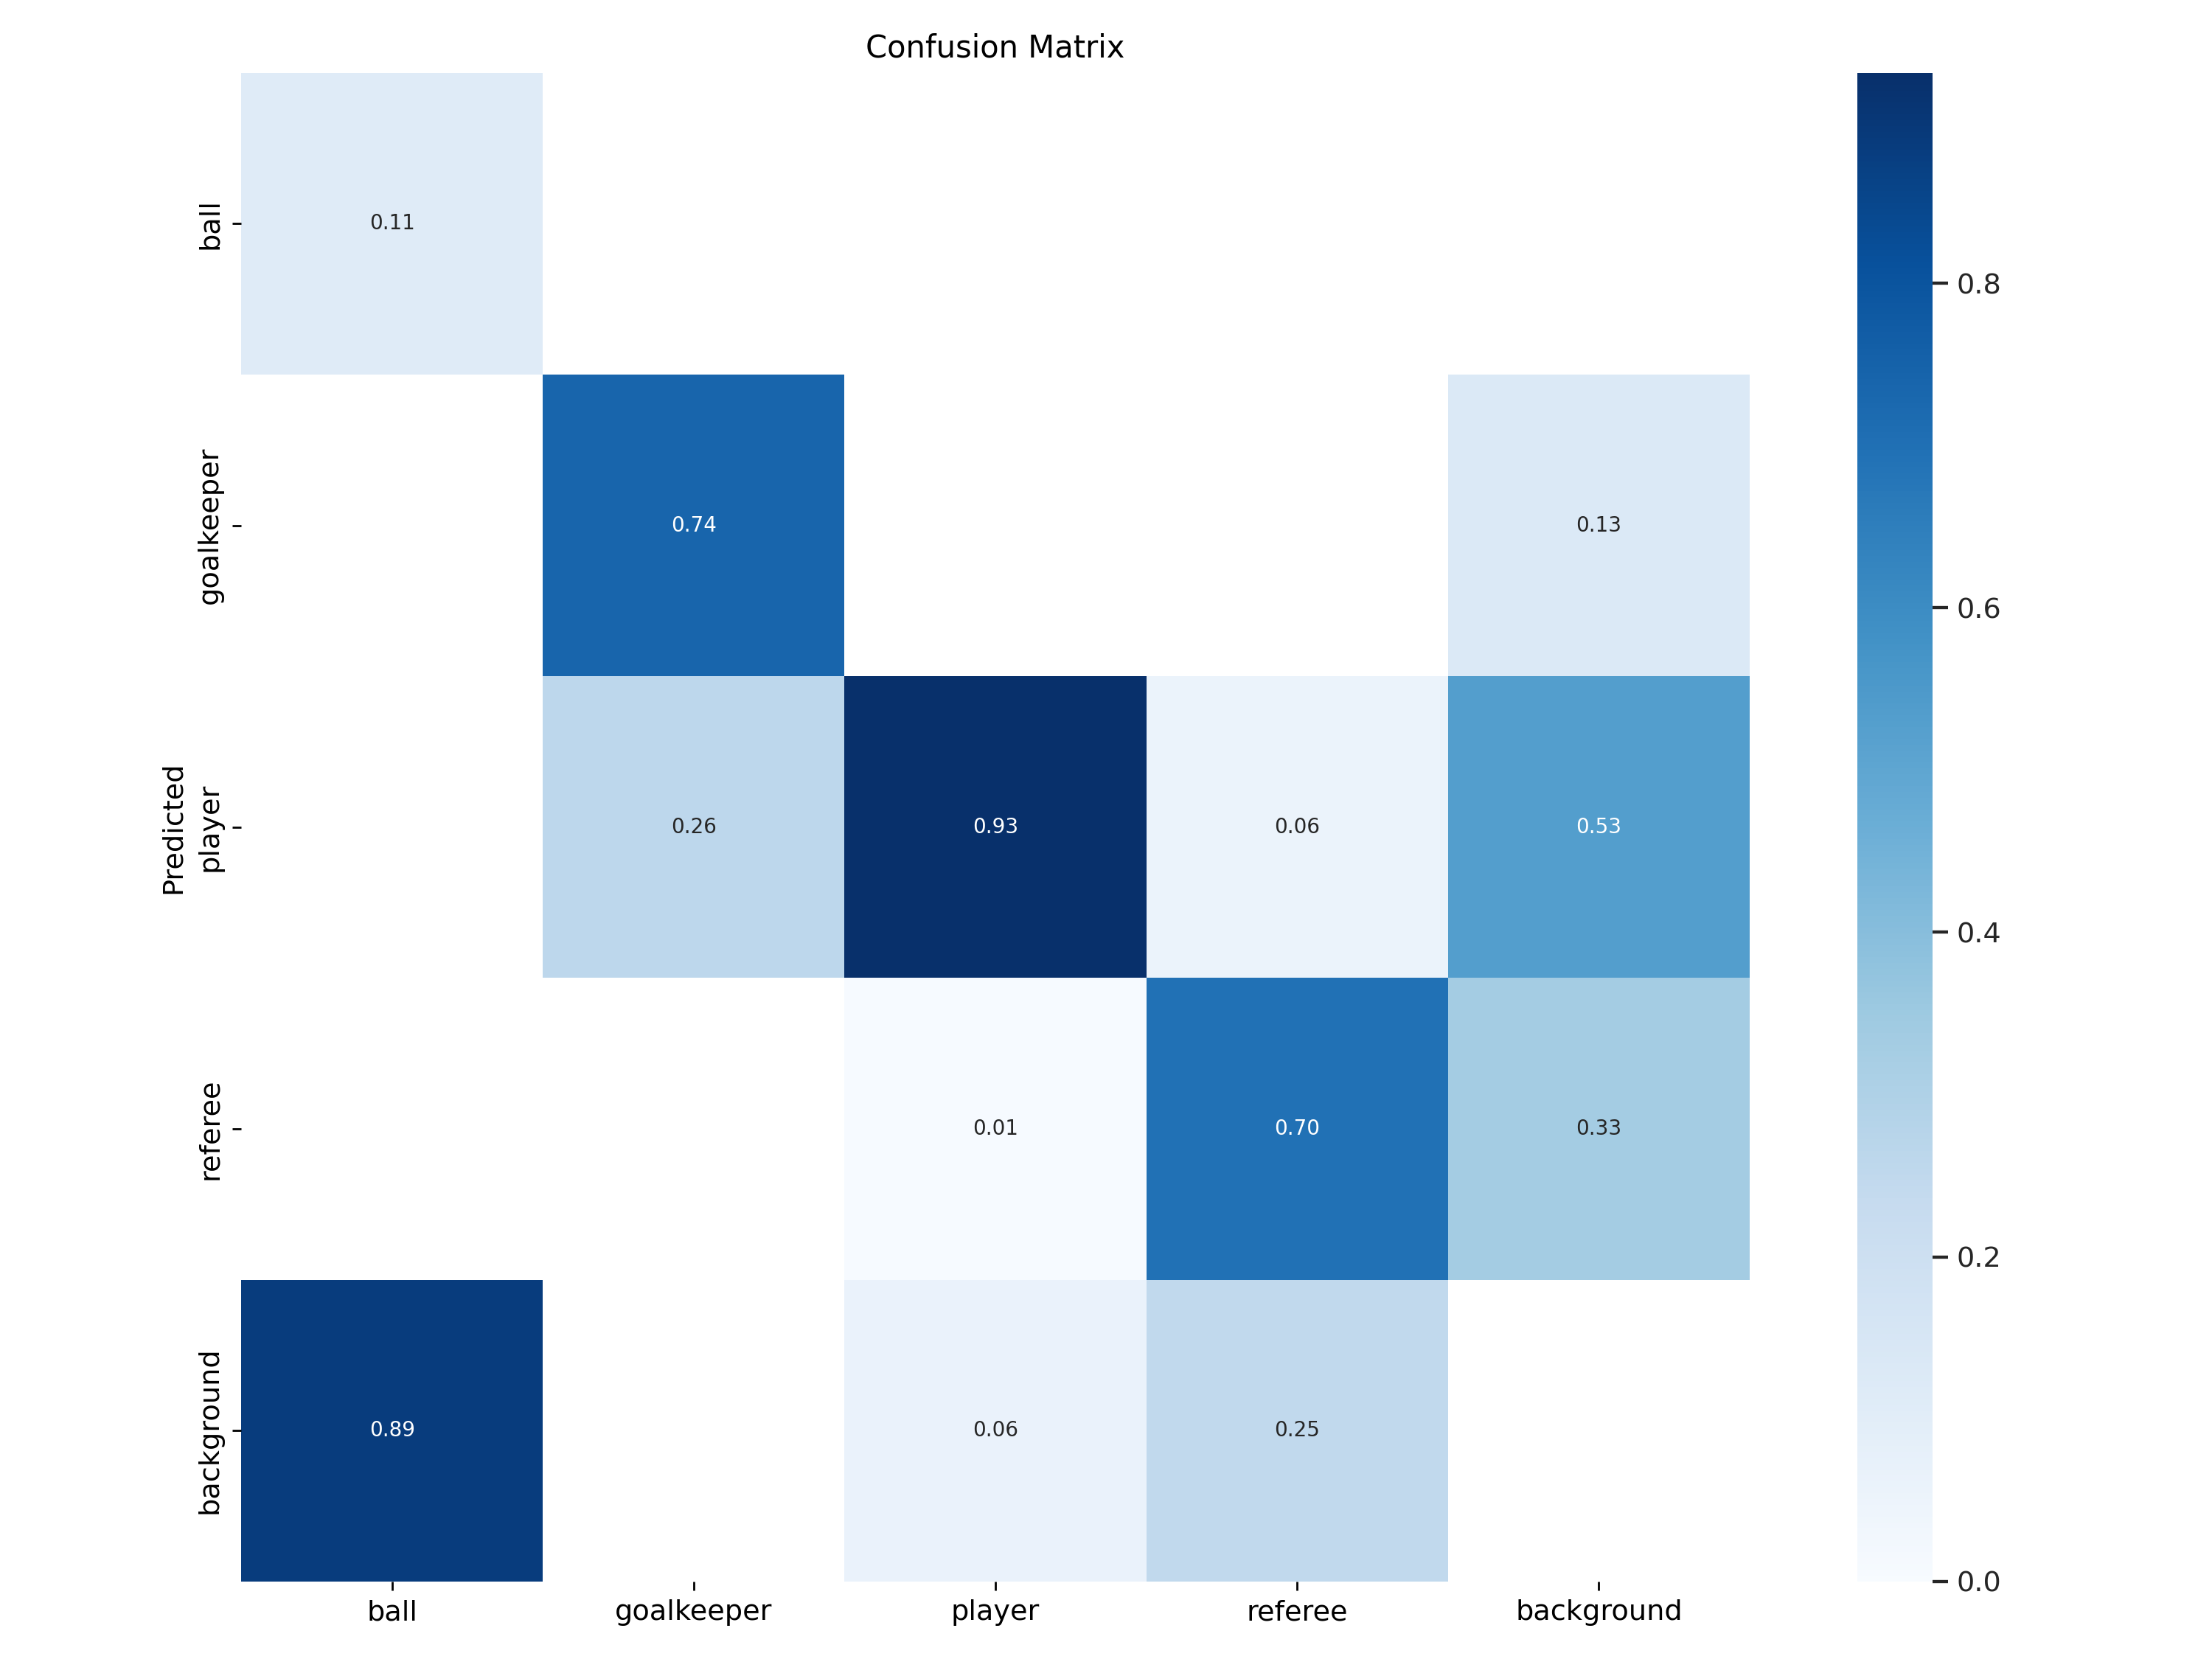

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/confusion_matrix.png", width=1000)

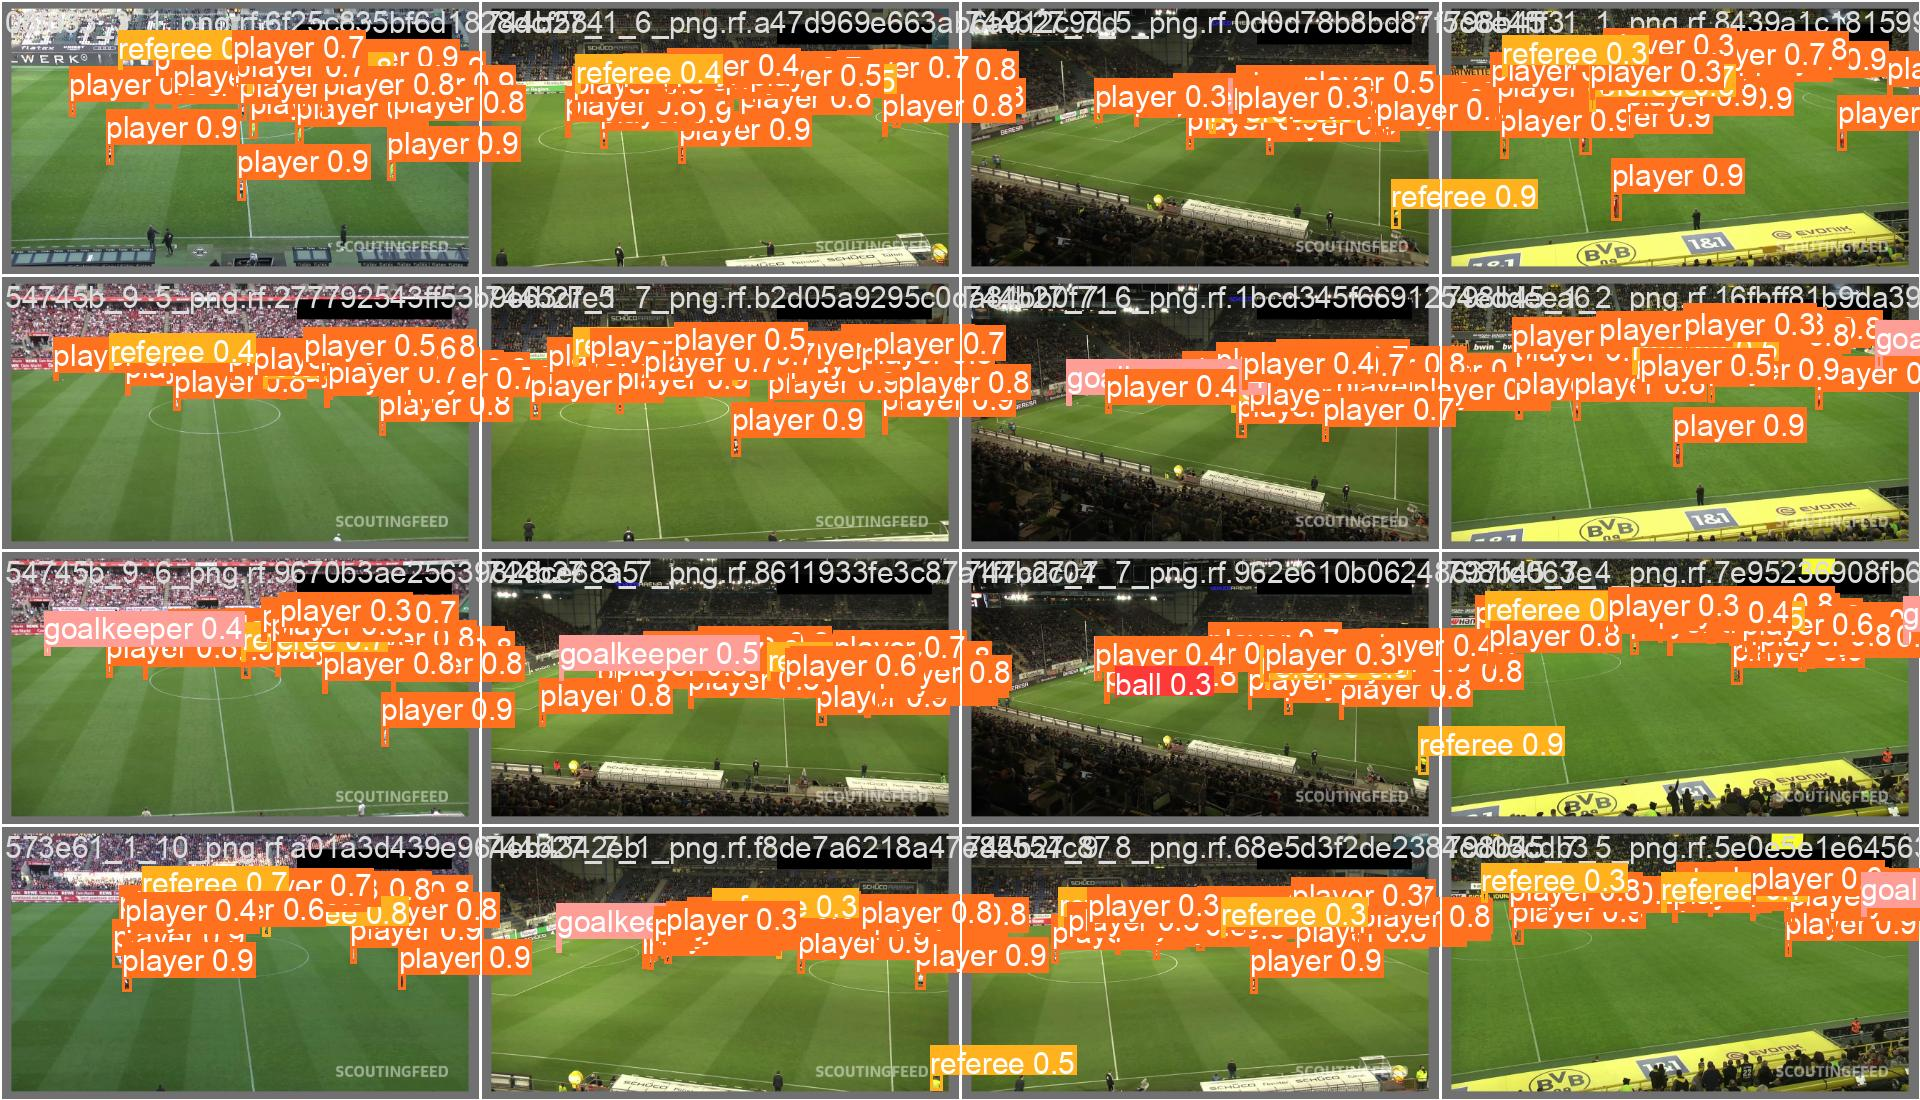

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/val_batch0_pred.jpg", width=1000)

## Validate Custom Model

In [ ]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt

/content/yolov9
val: data=/content/yolov9/football-players-detection-6/data.yaml, weights=['/content/yolov9/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25414044 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /content/yolov9/football-players-detection-6/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100% 38/38 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 2/2 [00:04<00:00,  2.22s/it]
                   all         38        905       0.91      0.689      0.759      0.528
                  ball     

## Inference with Custom Model

In [ ]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt \
--source {dataset.location}/test/images